In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from math import ceil
from scipy.linalg import sqrtm
from scipy.sparse.linalg import svds
from scipy.sparse import lil_matrix, csr_matrix, diags

## Algorithm

In [2]:
def gen_columns(M):
    '''
    Yileds columns of matrix M. Prevents from out-of-order access
    to matrix columns. It can be used to simulate data streaming.
    '''
    for i in range(M.shape[1]):
        yield M[:, i]

In [3]:
def sample_entry(M, delta):
    
    A = lil_matrix(M.shape, dtype=np.float64)
    
    for i in range(M.shape[1]):
        sample = np.random.choice(2, M.shape[0], p=[1 - delta, delta])
        A[:, i] = (M[:, i] * sample).reshape(-1, 1)

    return A

In [4]:
def SPCA(C, k):
    omega = np.random.randn(C.shape[1], k)
    omega = csr_matrix(omega)
    
    _C = lil_matrix(C.shape)
    
    # Trimming
    for i in range (C.shape[0]):
        if (C.getrow(i).count_nonzero() > 10):
            _C[i, :] = 0
        else:
            _C[i, :] = C[i, :]
    
    _C = _C.tocsr()
    
    diag_matrix = diags(diagonals=((_C.T @ _C).diagonal()), offsets=0, format="csr")
    
    F = _C.T @ _C - diag_matrix
    F = F.todense()
    power = int(np.ceil(5 * np.log(C.shape[1])))
        
    F = np.linalg.matrix_power(F, power)
    F = F @ omega
    Q, _ = np.linalg.qr(F)

    return Q[:, :k]

In [8]:
def SLA(M_cols, m, n, k, delta, l):
    
   #l_samples = list(np.random.choice(n, l, replace=True))
    l_samples = np.arange(l)
    
    M_l = np.empty((m, l)) # M_l is matrix of first l columns
    
    for j in l_samples:
        M_l[:, j] = next(M_cols)
        
    A_b1 = sample_entry(M_l, delta).tocsr()
    A_b2 = sample_entry(M_l, delta)
    
    del M_l
    
    Q = SPCA(A_b1, k)
    
    for i in range(m):
        if ((A_b2.getrow(i).count_nonzero()) > 2):
            A_b2[i, :] = 0
            
    for i in range(l):
        if ((A_b2.getcol(i).count_nonzero()) > 10 * delta * m):
            A_b2[:, i] = 0
    
    A_b2 = A_b2.tocsr()
    W = A_b2 @ Q
    V = np.zeros((n, k))
    
    V[:l, :] = A_b1.T @ W
    I = A_b1 @ V[:l, :]
    
    for t in range(l, n):
        sample = np.random.choice(2, m, p=[1 - delta, delta])
        A_t = next(M_cols) * sample
        V[t, :] = A_t.reshape(1, -1) @ W
        I += A_t.reshape(-1, 1) @ V[t, :].reshape(1, -1)
    
    R = sqrtm(V.T @ V)
    R = np.linalg.inv(R)
    
    U = (1.0 / delta) * (I @ R @ R.T)    
    M_k = U @ V.T
    
    return M_k      

## Evaluation

## Applications

### 1. Background/Foreground separation

In [9]:
def load_sequence_video(path, start, stop):
    
    files = sorted(os.listdir(path))
    frame = Image.open(os.path.join(path, files[0]))
    frame = frame.convert("L")
    frame = np.array(frame)
    
    frame_size = frame.shape
    size = frame.shape[0] * frame.shape[1]

    M = np.zeros((size, stop - start), np.float32)
    
    for i in range(start, stop):
        frame = Image.open(os.path.join(path, files[i])).convert("L")
        frame = np.array(frame) / 255.0
        M[:, i] = frame.reshape(-1)
    
    return M, frame_size


def display_result_video(M, L, S, idx):
    n = M.shape[2]
    
    for i in idx:
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 3, 1)
        plt.imshow(M[:,:,i], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(L[:,:,i], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(S[:,:,i], cmap='gray')
        plt.axis('off')

videos = [
            "./videos/Bootstrap",
            "./videos/Camouflage",
            "./videos/ForegroundAperture",
            "./videos/LightSwitch",
            "./videos/MovedObject",
            "./videos/TimeOfDay",
            "./videos/WavingTrees"
         ]

start = 0
stop = 3050
M_video, frame_size_video = load_sequence_video(videos[0], start, stop)

In [10]:
%%time

delta = 0.5
l = 10
k = 1

M_video = M_video.astype(np.float64)
m, n = M_video.shape
M_cols = gen_columns(M_video)

res_video = SLA(M_cols, m, n, k, delta, l)

CPU times: user 13.3 s, sys: 345 ms, total: 13.6 s
Wall time: 5.86 s


In [7]:
print("Approximated matrix rank:", np.linalg.matrix_rank(res_video))

Approximated matrix rank: 1


### Save videos for  separated background and foreground


In [8]:
import os

def save_bmps(dst, M, M_rec, frame_size):
    
    assert M.shape == M_rec.shape

    for j in range(M_rec.shape[1]):
        back_j = M_rec[:, j].reshape(frame_size)
        back_j = back_j / back_j.max()

        orig_j = M[:, j].reshape(frame_size)

        back_j = back_j * 255
        orig_j = orig_j * 255
        fore_j = np.clip(orig_j - back_j, 0, 255)
        
        full_j = np.concatenate([orig_j, back_j, fore_j], axis=1)
        full_j = Image.fromarray(full_j.astype(np.uint8))
        full_j.save(dst + 'b{0:05d}.bmp'.format(j))

In [9]:
path = "./original/"

os.makedirs(path, exist_ok=True)
save_bmps(path, M_video, res_video, frame_size_video)

In [10]:
%%bash

function make_video {
    ffmpeg -v error -framerate 60 -i $1/b0%04d.bmp -r 60 -y $1.mp4
}

for dir in original; do
    make_video $dir
done

In [13]:
M_video_final = M_video.reshape(*frame_size_video, -1)
L_video_final = res_video.reshape(*frame_size_video, -1)
L_video_final = L_video_final / L_video_final.max()
S_video_final = M_video_final - L_video_final
S_video_final[S_video_final < 0.15] = 0

print("Sparsity of matrix S:", np.count_nonzero(S_video_final) / np.prod(S_video_final.shape))

Sparsity of matrix S: 0.08924334016393443


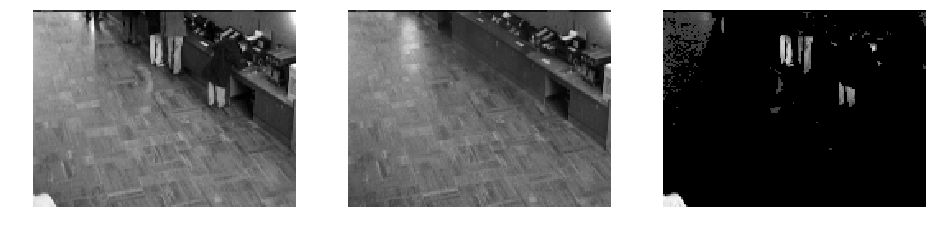

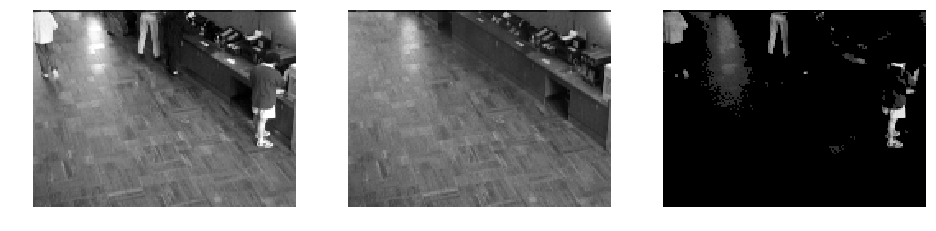

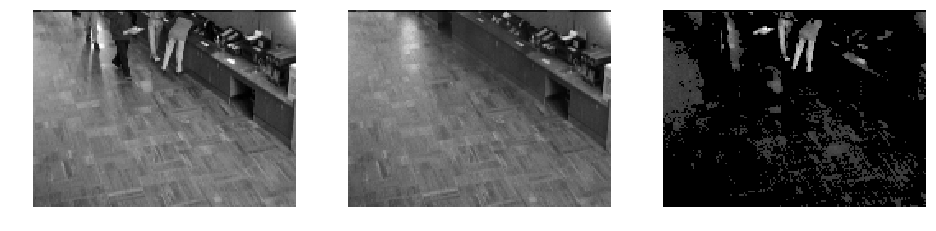

In [15]:
idx = [0, 5, 7]
m = 3
idx = np.random.choice(M_video_final.shape[-1], m)

display_result_video(M_video_final,
                     L_video_final,
                     S_video_final, idx)

### 2. Shadow removing

In [16]:
path = "./CroppedYale/yaleB02"

def load_sequence_faces(path):
    files = sorted(os.listdir(path))[-58:]
    frame = Image.open(os.path.join(path, files[25]))

    frame = np.array(frame)
    frame_size = frame.shape
    size = frame.shape[0] * frame.shape[1]

    M = np.zeros((size, len(files)))
    
    for i in range(len(files)):
        frame = Image.open(os.path.join(path, files[i]))
        frame = np.array(frame) / 255.0
        M[:, i] = frame.reshape(-1)
    
    return M, frame_size

M_faces, frame_size_faces = load_sequence_faces(path)

In [17]:
%%time

delta = 0.9
l = 5
k = 1

M_faces = M_faces.astype(np.float64)
m, n = M_faces.shape
M_cols = gen_columns(M_faces)

res_faces = SLA(M_cols, m, n, k, delta, l)

CPU times: user 8.28 s, sys: 95.7 ms, total: 8.37 s
Wall time: 7.18 s


In [30]:
M_faces_final = M_faces.reshape(*frame_size_faces, -1)
L_faces_final = res_faces.reshape(*frame_size_faces, -1)
L_faces_final = L_faces_final / L_faces_final.max()
S_faces_final = M_faces_final - L_faces_final

print("Sparsity of matrix S:", np.count_nonzero(S_faces_final) / np.prod(S_faces_final.shape))

Sparsity of matrix S: 1.0


In [31]:
def display_result_faces(M, L, S, idx):
    n = M.shape[2]
    
    for i in idx:
        plt.figure(figsize=(10, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(M[:,:,i], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(L[:,:,i], cmap='gray')
        plt.axis('off')

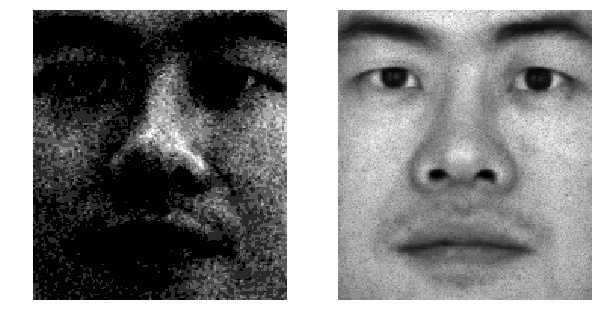

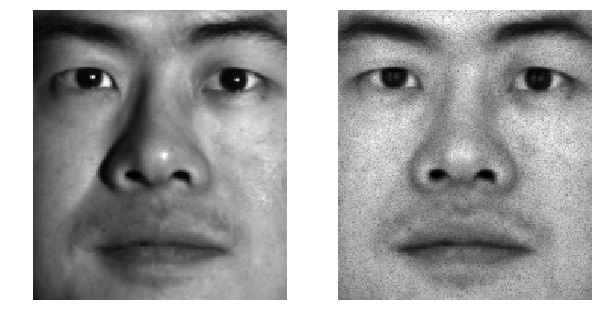

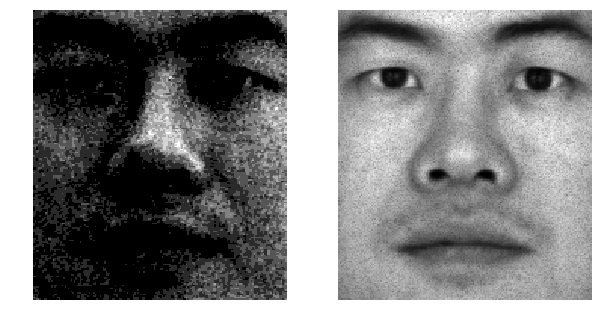

In [32]:
idx = [0, 5, 7]
m = 3
idx = np.random.choice(M_faces_final.shape[-1], m)

display_result_faces(M_faces_final,
                     L_faces_final,
                     S_faces_final, idx)